In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
%matplotlib inline
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [562]:
df = pd.read_csv('final_dataset.csv')

In [563]:
df.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,Weekly_Sales
0,1,1,2010-02-05,0,0,151315,42.31,2.572,24924.50
1,1,1,2010-02-12,1,0,151315,38.51,2.548,46039.49
2,1,1,2010-02-19,0,0,151315,39.93,2.514,41595.55
3,1,1,2010-02-26,0,0,151315,46.63,2.561,19403.54
4,1,1,2010-03-05,0,0,151315,46.50,2.625,21827.90


In [564]:
df = df.drop(['Store','Dept','IsHoliday','Type','Size','Temperature','Fuel_Price'], axis =1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 2 columns):
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


In [565]:
df = df.drop_duplicates(subset=['Date'])

In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [567]:
df.set_index('Date', inplace = True)

In [568]:
df.index = pd.to_datetime(df.index)
df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [569]:
df.index.nunique()

143

In [570]:
df.nunique()

Weekly_Sales    143
dtype: int64

In [571]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
Weekly_Sales    143 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


In [572]:
df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [573]:
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
Weekly_Sales    143 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


In [574]:
df.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

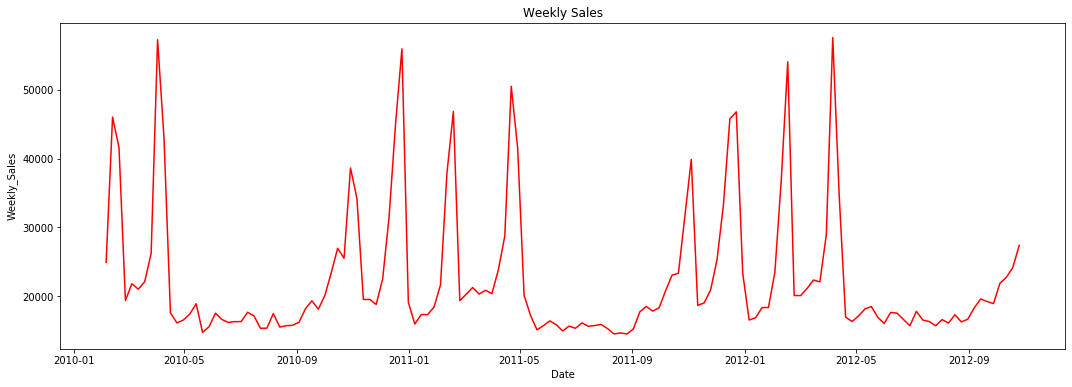

In [575]:
plt.figure(figsize = (18,6))
plt.plot('Weekly_Sales', 'r',data=df)
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.title('Weekly Sales')
plt.show()

# Test/Train Split

In [576]:
train_set = df.iloc[:120]
test_set = df.iloc[120:]

In [577]:
len(train_set)

120

In [578]:
len(test_set)

23

In [579]:
train_set_array = train_set.iloc[:,:].values
test_set_array = test_set.iloc[:,:].values

print("Shape of train, val and test array:\n",train_set_array.shape,"\n",test_set_array.shape)

Shape of train, val and test array:
 (120, 1) 
 (23, 1)


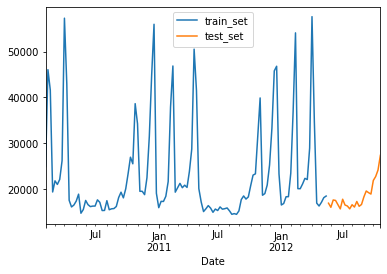

In [580]:
ax = train_set.plot()
test_set.plot(ax=ax)
plt.legend(['train_set', 'test_set'])

In [581]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train_set)

scaled_train = scaler.transform(train_set)
scaled_test = scaler.transform(test_set)

# Creating Time Series Generator

In [582]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [583]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [584]:
X,y = generator[0]

In [585]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.24125398 0.73167583]
Predict this y: 
 [[0.62845981]]


In [586]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [587]:
# define generator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=3)

In [588]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(250, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.add(Dropout(0.5))
model.add(Dense(1,kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 10)             480       
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 10)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 250)               261000    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 251       
_________________________________________________________________
dropout_19 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 261,733
Trainable params: 261,733
Non-trainable params: 0
_________________________________________________________________


In [589]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
# fit model
model.fit_generator(generator,epochs=25,callbacks=[early_stop],steps_per_epoch=100)

Epoch 1/25
100/100 [==============================] - 9s 89ms/step - loss: 0.0992
Epoch 2/25
100/100 [==============================] - 4s 40ms/step - loss: 0.0786
Epoch 3/25
100/100 [==============================] - 3s 32ms/step - loss: 0.0745
Epoch 4/25
100/100 [==============================] - 3s 29ms/step - loss: 0.0656
Epoch 5/25
100/100 [==============================] - 3s 29ms/step - loss: 0.0676
Epoch 00005: early stopping


In [590]:
model.history.history.keys()

dict_keys(['loss'])

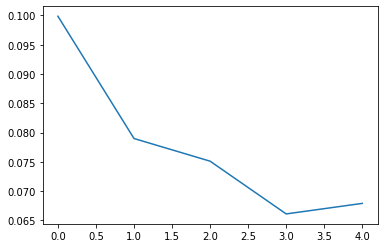

In [591]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [592]:
first_eval_batch = scaled_train[-7:]

In [593]:
first_eval_batch

array([[1.        ],
       [0.46793536],
       [0.05664462],
       [0.04204484],
       [0.06062211],
       [0.08423763],
       [0.09245019]])

In [594]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [595]:
model.predict(first_eval_batch)

array([[0.17736575]], dtype=float32)

In [596]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [597]:
current_batch.shape

(1, 7, 1)

In [598]:
current_batch

array([[[1.        ],
        [0.46793536],
        [0.05664462],
        [0.04204484],
        [0.06062211],
        [0.08423763],
        [0.09245019]]])

In [599]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[4.67935361e-01],
        [5.66446211e-02],
        [4.20448383e-02],
        [6.06221149e-02],
        [8.42376277e-02],
        [9.24501942e-02],
        [9.90000000e+01]]])

In [600]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_set)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [601]:
true_predictions = scaler.inverse_transform(test_predictions)

In [602]:
test_set['Predictions'] = true_predictions

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Error%

In [603]:
#test[]
test_set['delta'] = test_set['Weekly_Sales'] - test_set['Predictions'] 
test_set['Error%'] = test_set['delta']/test_set['Weekly_Sales']*100
test_set.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Weekly_Sales,Predictions,delta,Error%
Date,,,,
2012-05-25,16963.55,22173.808028,-5210.258028,-30.714432
2012-06-01,16065.49,21860.741896,-5795.251896,-36.072674
2012-06-08,17666.00,21744.792356,-4078.792356,-23.088375
2012-06-15,17558.82,21887.286680,-4328.466680,-24.651239
2012-06-22,16633.41,22058.403819,-5424.993819,-32.615043
